In [1]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.9.1+cu102]


In [2]:
def torch2np(x_torch):
    if x_torch is None:
        x_np = None
    else:
        x_np = x_torch.detach().cpu().numpy()
    return x_np
def np2torch(x_np,device='cuda:0'):
    if x_np is None:
        x_torch = None
    else:
        x_torch = torch.tensor(x_np,dtype=torch.float32,device=device)
    return x_torch
print ("Done.")

Done.


In [3]:
class VectorQuantizer(nn.Module):
    def __init__(
                self,
                embedding_num   = 10,
                embedding_dim   = 3,
                commitment_beta = 0.25,
                device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
                ):
        super(VectorQuantizer, self).__init__()
        self.embedding_num   = embedding_num
        self.embedding_dim   = embedding_dim
        self.commitment_beta = commitment_beta
        self.device    = device
        self.embedding = nn.Embedding(self.embedding_num, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.embedding_num, 1/self.embedding_num)

    def compute_loss(
                    self,
                    z_e,
                    z_q
                    ):
        codebook_loss   = F.mse_loss(z_e.detach(), z_q)
        commitment_loss = F.mse_loss(z_e, z_q.detach())
        return codebook_loss + self.commitment_beta*commitment_loss

    def forward(
                self, 
                z = torch.randn(1, 15)
                ):
        z_dim = z.shape[1]
        z = z.reshape(-1, int(z_dim/self.embedding_dim), self.embedding_dim)
        z_e = z.view(-1, self.embedding_dim)
        distances = torch.sum(z_e**2, dim=1, keepdim=True)\
                    + torch.sum(self.embedding.weight**2, dim=1, keepdim=False)\
                    - 2*torch.matmul(z_e, self.embedding.weight.t())
        q_x = torch.argmin(distances, dim=1).unsqueeze(1)
        q_x_one_hot = torch.zeros(q_x.shape[0], self.embedding_num).to(self.device)
        q_x_one_hot.scatter_(1, q_x, 1)
        z_q  = torch.matmul(q_x_one_hot, self.embedding.weight).view(z.shape)
        loss = self.compute_loss(z, z_q)
        z_q = z + (z_q-z).detach()
        return z_q.reshape(-1, z_dim), loss

In [4]:
class VectorQuantizedVariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        name     = 'VQVAE',              
        x_dim    = 784,              # input dimension
        z_dim    = 15,               # latent dimension
        h_dims   = [64,32],          # hidden dimensions of encoder (and decoder)
        embedding_num   = 10,        # For VQ parameters
        embedding_dim   = 3,         # For VQ parameters
        commitment_beta = 0.25,      # For VQ parameters
        actv_enc = nn.ReLU(),        # encoder activation
        actv_dec = nn.ReLU(),        # decoder activation
        actv_out = None,             # output activation
        var_max  = None,             # maximum variance
        device   = 'cpu'
        ):
        """
            Initialize
        """
        super(VectorQuantizedVariationalAutoEncoder, self).__init__()
        self.name     = name
        self.x_dim    = x_dim
        self.z_dim    = z_dim
        self.h_dims   = h_dims
        self.embedding_num   = embedding_num
        self.embedding_dim   = embedding_dim
        self.commitment_beta = commitment_beta
        self.actv_enc = actv_enc
        self.actv_dec = actv_dec
        self.actv_out = actv_out
        self.var_max  = var_max
        self.device   = device
        # Initialize VQ class
        self.VQ = VectorQuantizer(self.embedding_num, self.embedding_dim, self.commitment_beta).to(self.device)
        # Initialize layers
        self.init_layers()
        self.init_params()
                
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        
        # Encoder part
        h_dim_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = \
                self.actv_enc
            h_dim_prev = h_dim
        self.layers['z_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        
        # Decoder part
        h_dim_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = \
                self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.cvae_parameters = nn.ParameterDict(self.param_dict)
        
    def x_to_z(
        self,
        x = torch.randn(2,784)
        ):
        """
            x to z
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z = self.layers['z_lin'](net)
        return z
    
    def z_to_x_recon(
        self,
        z
        ):
        """
            z and c to x_recon
        """
        net, _ = self.VQ(z)
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def z_e_to_x_recon(
        self,
        z_e
        ):
        """
            z and c to x_recon
        """
        net = z_e
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def x_to_x_recon(
        self,
        x = torch.randn(2,784),
        ):
        """
            x to x_recon
        """
        z = self.x_to_z(x=x)
        x_recon = self.z_to_x_recon(z=z)
        return x_recon
    
    def init_params(self,seed=0):
        """
            Initialize parameters
        """
        # Fix random seed
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        # Init
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.01)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def loss_recon(
        self,
        x               = torch.randn(2,784),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Recon loss
        """
        x_recon = self.x_to_x_recon(x=x)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        return recon_loss_gain*torch.mean(errs)
        
    def loss_total(
        self,
        x               = torch.randn(2,784),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Total loss
        """
        loss_recon_out = self.loss_recon(
            x               = x,
            LOSS_TYPE       = LOSS_TYPE,
            recon_loss_gain = recon_loss_gain
        )
        z = self.x_to_z(x)
        _, loss_vq = self.VQ(z)
        loss_total_out = loss_recon_out + loss_vq
        info           = {'loss_total_out' : loss_total_out,
                          'loss_recon_out' : loss_recon_out,
                          'loss_vq'        : loss_vq}
        return loss_total_out,info

    def debug_plot_img(
        self,
        x_train_np     = np.zeros((60000,784)),  # to plot encoded latent space 
        y_train_np     = np.zeros((60000)),      # to plot encoded latent space 
        c_train_np     = np.zeros((60000,10)),   # to plot encoded latent space
        x_test_np      = np.zeros((10000,784)),
        c_test_np      = np.zeros((10000,10)),
        c_vecs         = np.eye(10,10),
        n_sample       = 10,
        img_shape      = (28,28),
        img_cmap       = 'gray',
        figsize_image  = (10,3.25),
        figsize_latent = (10,3.25),
        DPP_GEN        = False,
        dpp_hyp        = {'g':1.0,'l':0.1}
        ):
        """
            Debug plot
        """
        n_train       = x_train_np.shape[0]
        x_train_torch = np2torch(x_train_np, device=self.device)
        # Reconstruct
        x_test_torch  = np2torch(x_test_np, device=self.device)
        n_test        = x_test_np.shape[0]
        rand_idxs     = np.random.permutation(n_test)[:n_sample]
        x_recon = self.x_to_x_recon(x=x_test_torch[rand_idxs,:]).detach().cpu().numpy()
        # Generation
        random_integers  = np.random.permutation(self.embedding_num)[:n_sample]
        random_embedding = self.VQ.embedding.weight.data[random_integers, :]
        x_sample = self.z_e_to_x_recon(z_e=random_embedding).detach().cpu().numpy()
        # Plot images to reconstruct
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_test_np[rand_idxs[s_idx],:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Images to Reconstruct",fontsize=15);plt.show()
        
        # Plot reconstructed images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_recon[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Reconstructed Images",fontsize=15);plt.show()

        # Plot generated images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_sample[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Generated Images",fontsize=15);plt.show()

In [5]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch               = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch               = mnist_train.targets
x_test_torch                = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch                = mnist_test.targets
x_train_np,x_test_np        = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np        = torch2np(y_train_torch),torch2np(y_test_torch)
c_train_np,c_test_np        = np.eye(10,10)[y_train_np],np.eye(10,10)[y_test_np]
n_train,n_test              = x_train_np.shape[0],x_test_np.shape[0]
c_train_torch,c_test_torch  = np2torch(c_train_np),np2torch(c_test_np)
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("c_train_np:%s c_test_np:%s"%(c_train_np.shape,c_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

/home/sunghyun/.pyenv/versions/3.8.13/envs/main/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


x_train_np:(60000, 784) x_test_np:(10000, 784)
c_train_np:(60000, 10) c_test_np:(10000, 10)
n_train:[60000] n_test:[10000]


[VQVAE] instantiated with device:[cuda:0]
Start training.
[0/100] total:[0.099] recon:[0.094] vq:[44.653]


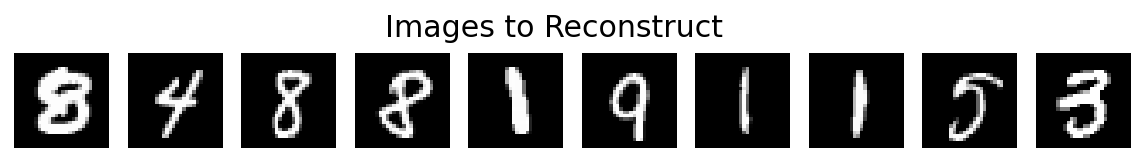

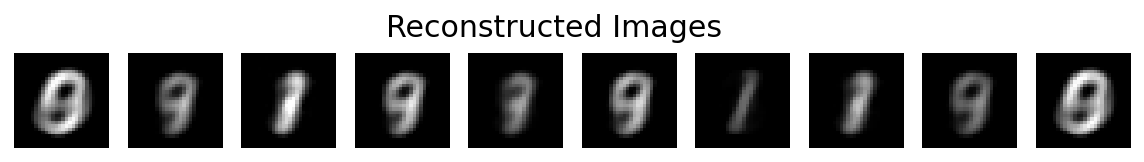

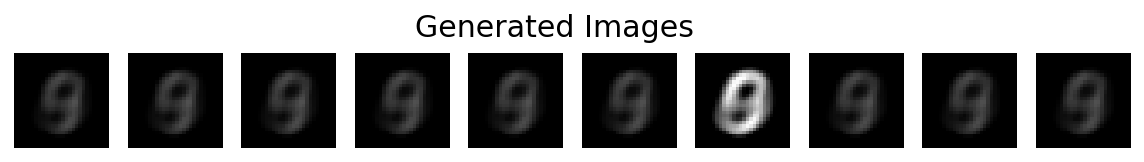

[1/100] total:[0.085] recon:[0.083] vq:[26.692]
[2/100] total:[0.081] recon:[0.078] vq:[31.251]
[3/100] total:[0.081] recon:[0.075] vq:[62.652]
[4/100] total:[0.080] recon:[0.072] vq:[77.388]
[5/100] total:[0.079] recon:[0.070] vq:[84.751]


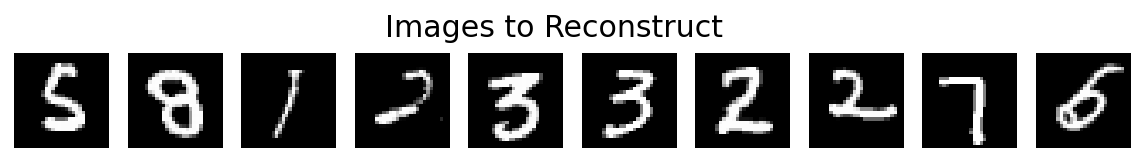

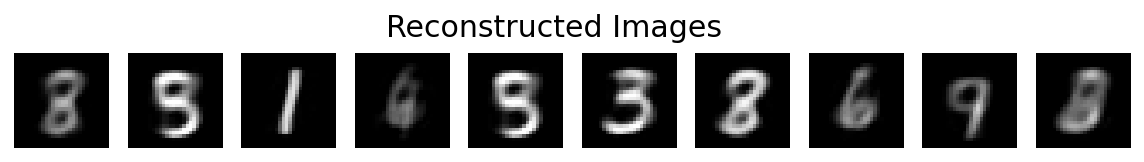

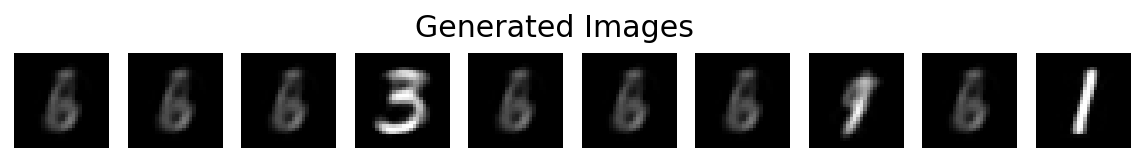

[6/100] total:[0.079] recon:[0.069] vq:[101.533]
[7/100] total:[0.081] recon:[0.068] vq:[131.228]
[8/100] total:[0.082] recon:[0.066] vq:[153.550]
[9/100] total:[0.082] recon:[0.066] vq:[164.399]
[10/100] total:[0.082] recon:[0.065] vq:[171.406]


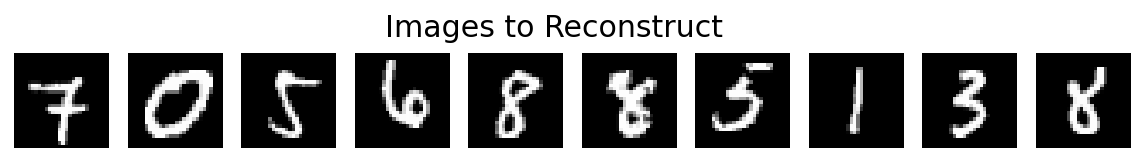

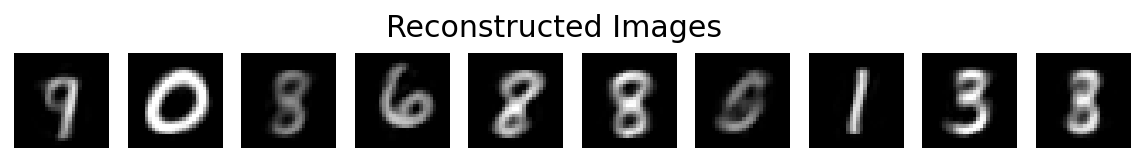

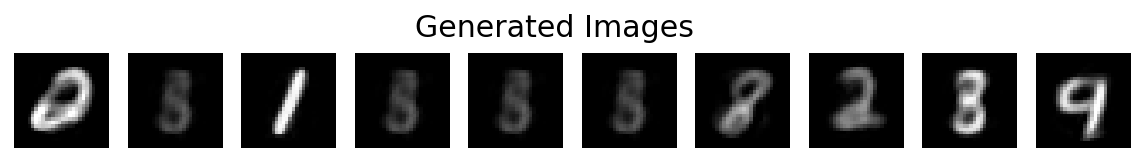

[11/100] total:[0.082] recon:[0.065] vq:[173.459]
[12/100] total:[0.082] recon:[0.064] vq:[179.085]
[13/100] total:[0.083] recon:[0.064] vq:[185.323]
[14/100] total:[0.083] recon:[0.064] vq:[191.691]
[15/100] total:[0.083] recon:[0.063] vq:[194.507]


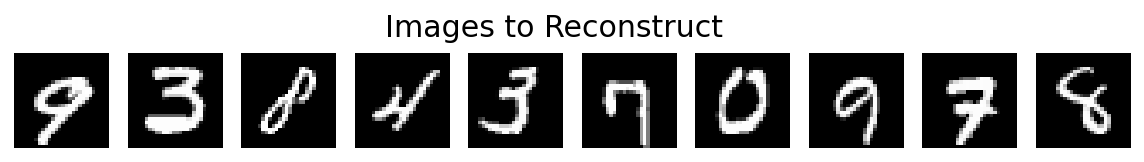

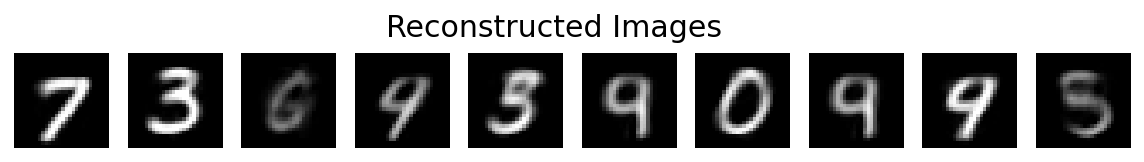

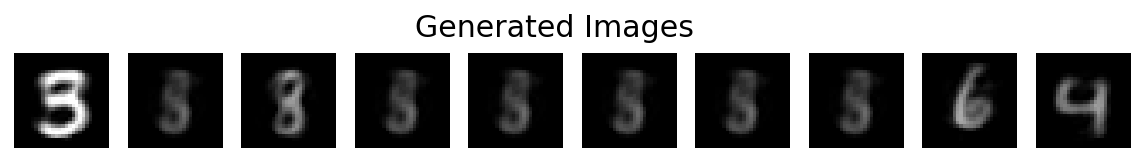

[16/100] total:[0.083] recon:[0.063] vq:[199.877]
[17/100] total:[0.083] recon:[0.063] vq:[206.600]
[18/100] total:[0.084] recon:[0.062] vq:[211.692]
[19/100] total:[0.083] recon:[0.062] vq:[213.815]
[20/100] total:[0.084] recon:[0.062] vq:[216.647]


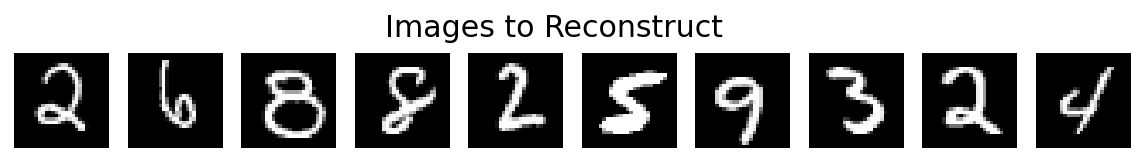

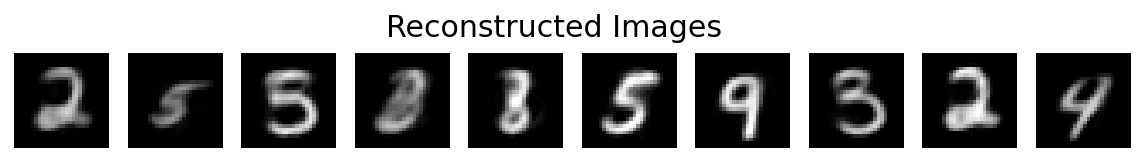

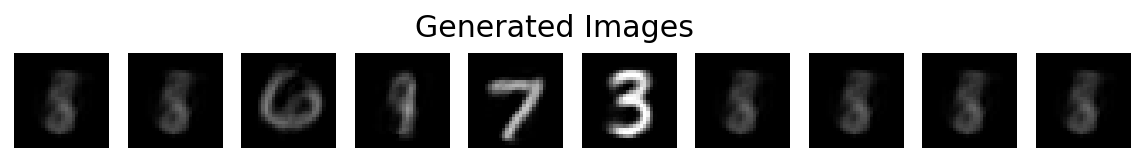

[21/100] total:[0.084] recon:[0.062] vq:[216.679]
[22/100] total:[0.084] recon:[0.062] vq:[218.622]
[23/100] total:[0.084] recon:[0.062] vq:[220.805]
[24/100] total:[0.084] recon:[0.062] vq:[223.340]
[25/100] total:[0.084] recon:[0.062] vq:[226.758]


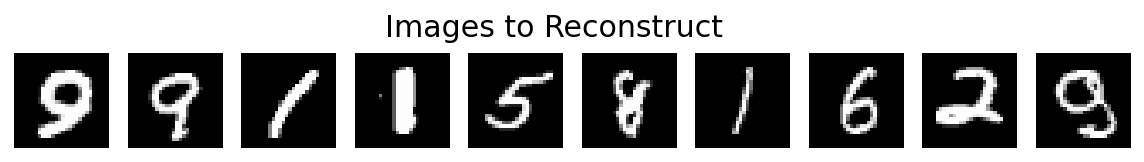

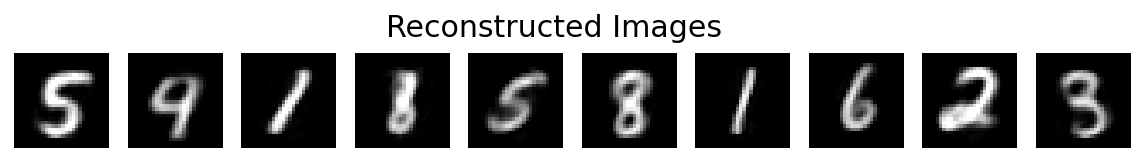

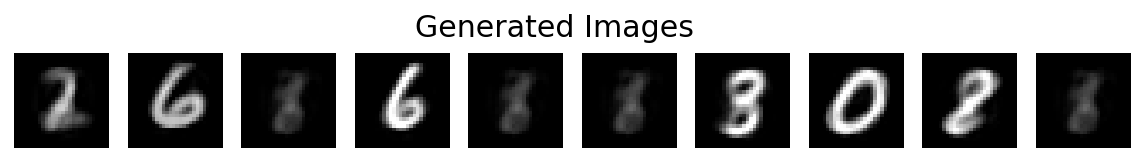

[26/100] total:[0.085] recon:[0.061] vq:[230.911]
[27/100] total:[0.085] recon:[0.061] vq:[234.622]
[28/100] total:[0.085] recon:[0.061] vq:[236.442]
[29/100] total:[0.085] recon:[0.061] vq:[237.923]
[30/100] total:[0.085] recon:[0.061] vq:[241.255]


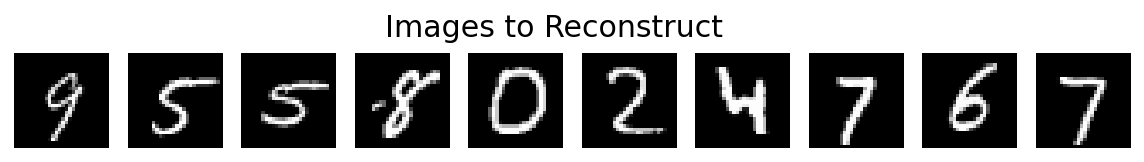

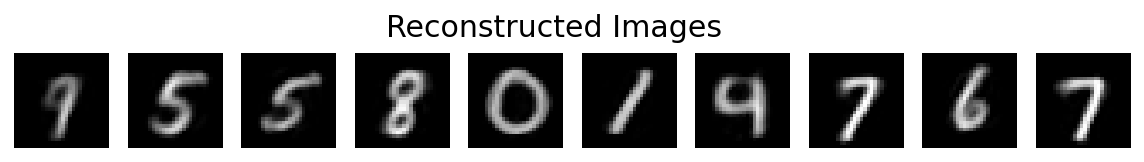

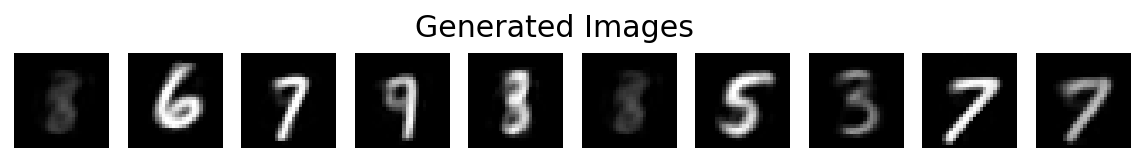

[31/100] total:[0.085] recon:[0.061] vq:[242.262]
[32/100] total:[0.085] recon:[0.061] vq:[243.636]
[33/100] total:[0.085] recon:[0.061] vq:[245.439]
[34/100] total:[0.085] recon:[0.060] vq:[246.829]
[35/100] total:[0.085] recon:[0.060] vq:[249.635]


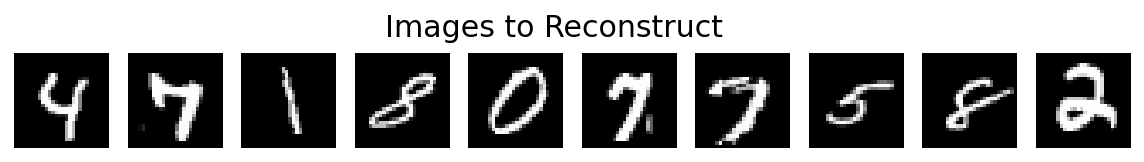

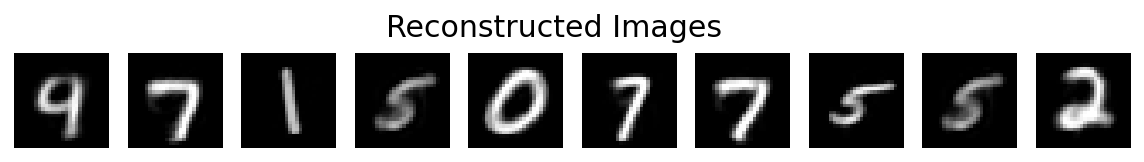

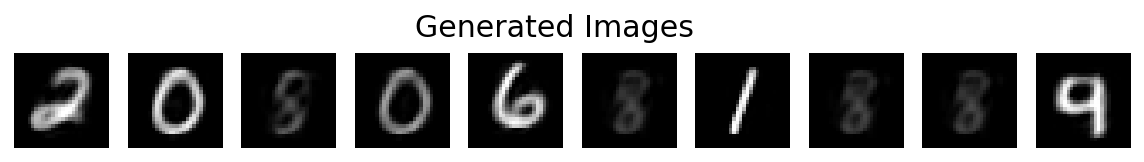

[36/100] total:[0.085] recon:[0.060] vq:[251.919]
[37/100] total:[0.085] recon:[0.060] vq:[252.282]
[38/100] total:[0.085] recon:[0.060] vq:[253.945]
[39/100] total:[0.086] recon:[0.060] vq:[255.048]
[40/100] total:[0.085] recon:[0.060] vq:[254.587]


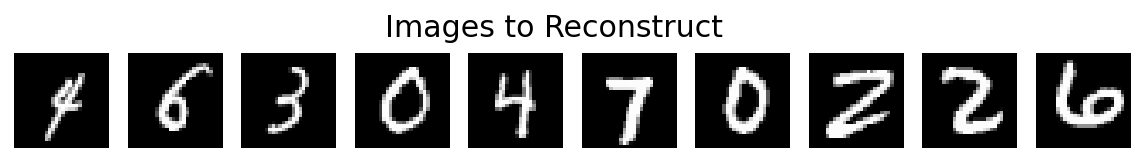

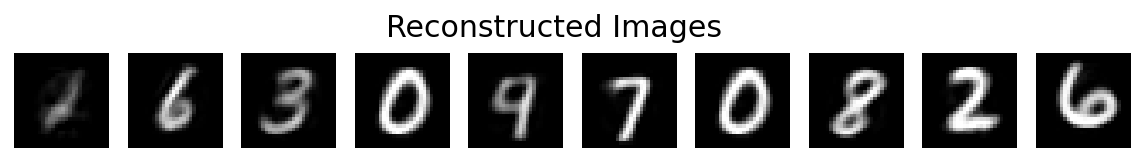

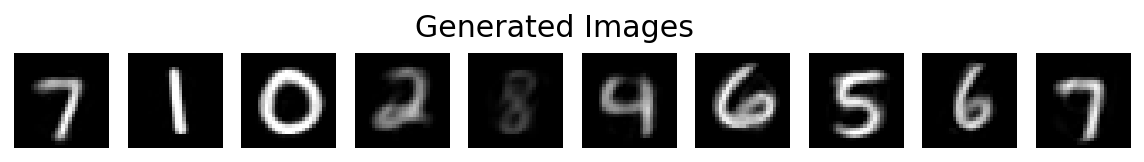

[41/100] total:[0.085] recon:[0.060] vq:[254.541]
[42/100] total:[0.085] recon:[0.060] vq:[255.081]
[43/100] total:[0.086] recon:[0.060] vq:[257.595]
[44/100] total:[0.086] recon:[0.060] vq:[258.337]
[45/100] total:[0.086] recon:[0.060] vq:[258.621]


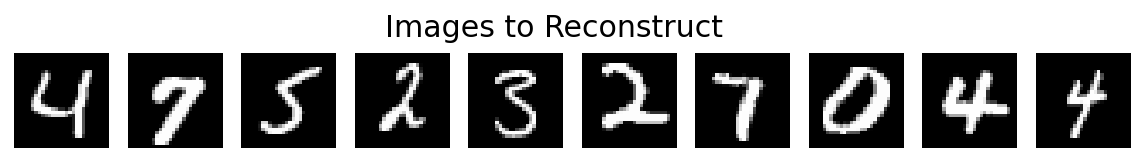

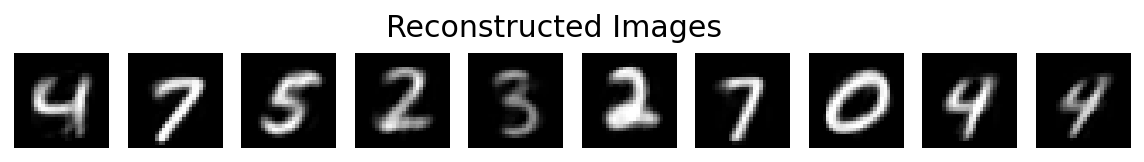

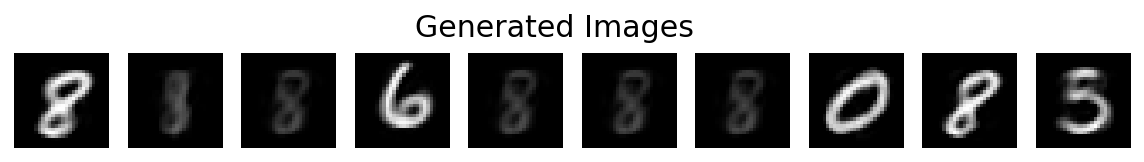

[46/100] total:[0.086] recon:[0.060] vq:[259.468]
[47/100] total:[0.086] recon:[0.060] vq:[260.441]
[48/100] total:[0.086] recon:[0.060] vq:[261.366]
[49/100] total:[0.086] recon:[0.060] vq:[260.861]
[50/100] total:[0.086] recon:[0.060] vq:[261.095]


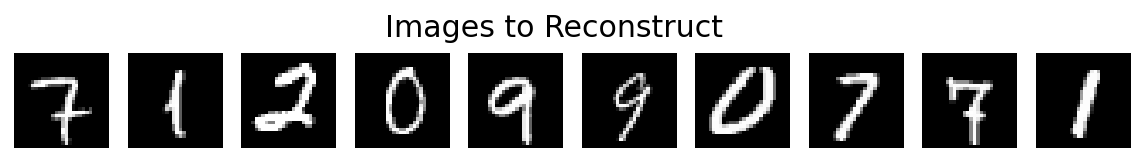

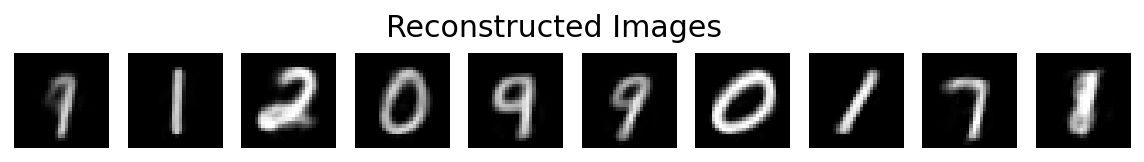

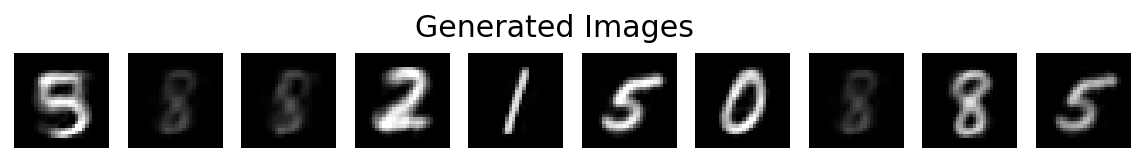

[51/100] total:[0.086] recon:[0.060] vq:[261.379]
[52/100] total:[0.086] recon:[0.060] vq:[261.722]
[53/100] total:[0.086] recon:[0.059] vq:[262.594]
[54/100] total:[0.086] recon:[0.059] vq:[261.739]
[55/100] total:[0.086] recon:[0.059] vq:[264.870]


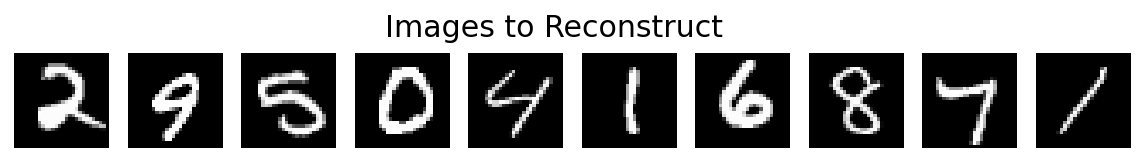

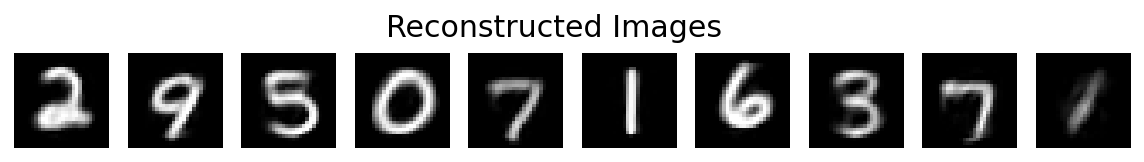

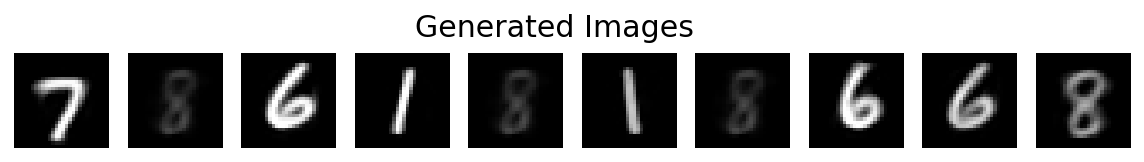

[56/100] total:[0.086] recon:[0.059] vq:[265.260]
[57/100] total:[0.086] recon:[0.059] vq:[266.712]
[58/100] total:[0.086] recon:[0.059] vq:[267.352]
[59/100] total:[0.086] recon:[0.059] vq:[267.060]
[60/100] total:[0.086] recon:[0.059] vq:[268.216]


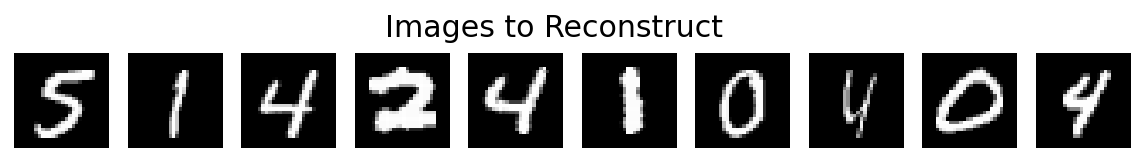

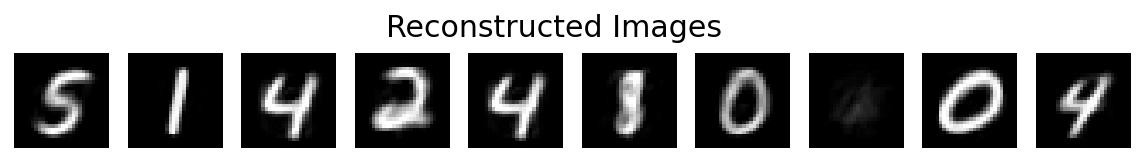

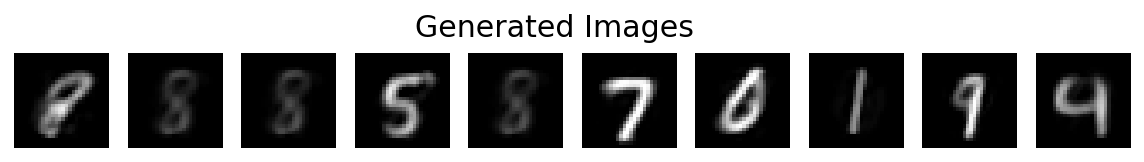

[61/100] total:[0.086] recon:[0.059] vq:[267.372]
[62/100] total:[0.086] recon:[0.059] vq:[267.574]
[63/100] total:[0.086] recon:[0.059] vq:[267.750]
[64/100] total:[0.086] recon:[0.059] vq:[268.031]
[65/100] total:[0.086] recon:[0.059] vq:[268.742]


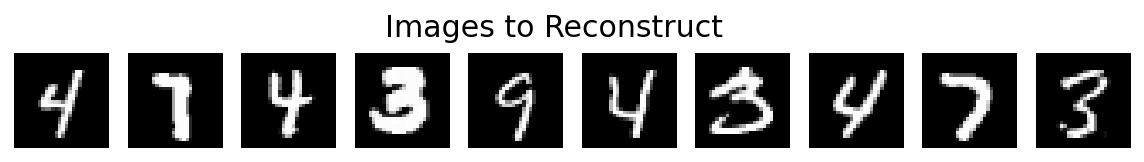

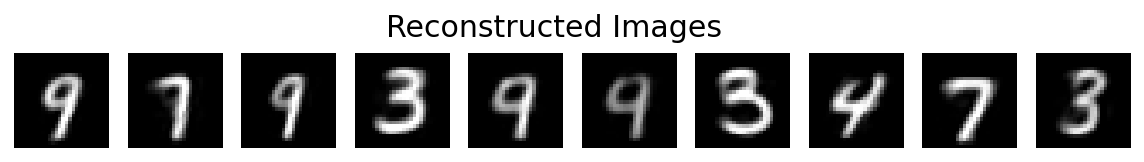

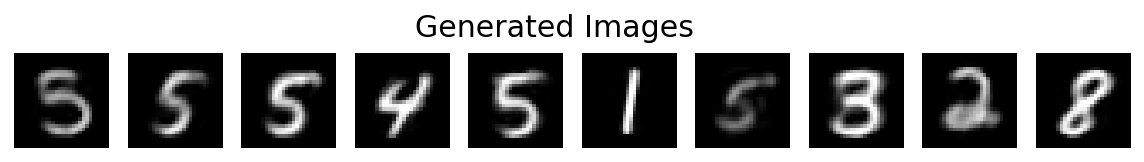

[66/100] total:[0.086] recon:[0.059] vq:[268.796]
[67/100] total:[0.086] recon:[0.059] vq:[269.335]
[68/100] total:[0.086] recon:[0.059] vq:[269.694]
[69/100] total:[0.086] recon:[0.059] vq:[270.612]
[70/100] total:[0.086] recon:[0.059] vq:[271.720]


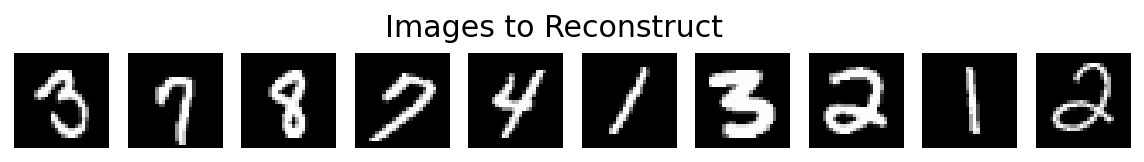

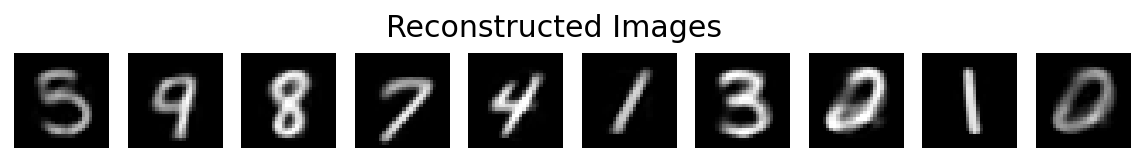

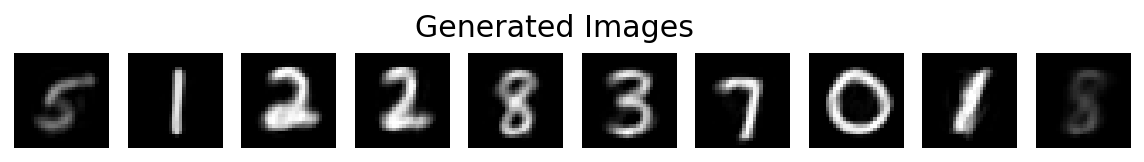

[71/100] total:[0.086] recon:[0.059] vq:[273.465]
[72/100] total:[0.086] recon:[0.059] vq:[272.719]
[73/100] total:[0.086] recon:[0.059] vq:[273.456]
[74/100] total:[0.086] recon:[0.059] vq:[274.965]
[75/100] total:[0.086] recon:[0.059] vq:[274.844]


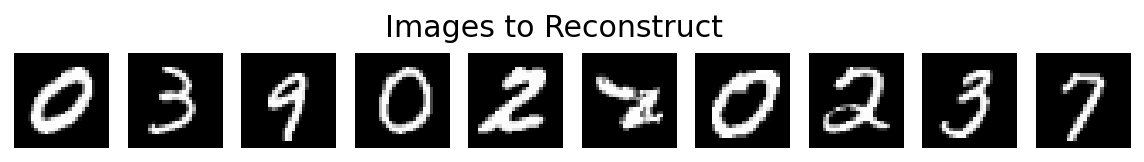

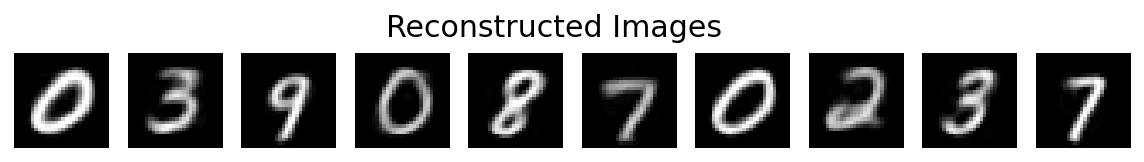

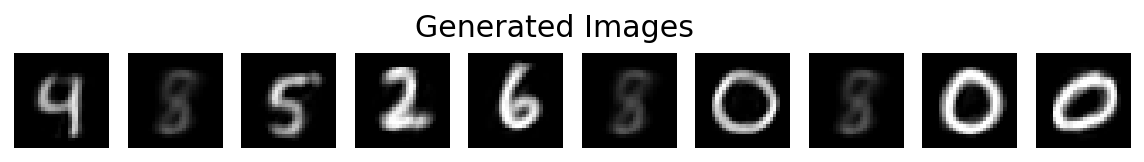

[76/100] total:[0.086] recon:[0.059] vq:[275.013]
[77/100] total:[0.086] recon:[0.059] vq:[275.154]
[78/100] total:[0.086] recon:[0.058] vq:[275.701]
[79/100] total:[0.086] recon:[0.058] vq:[275.762]
[80/100] total:[0.086] recon:[0.058] vq:[278.111]


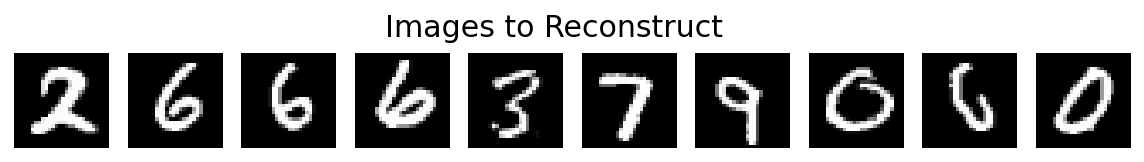

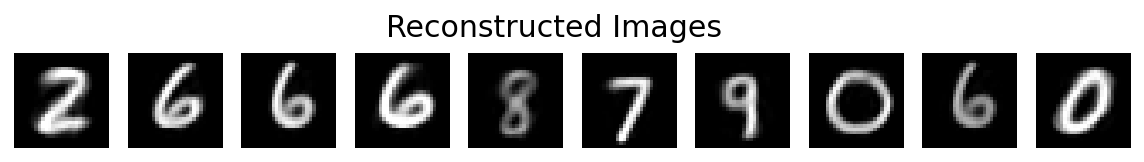

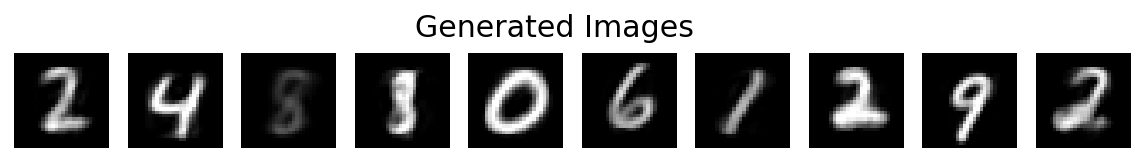

[81/100] total:[0.086] recon:[0.058] vq:[278.499]
[82/100] total:[0.086] recon:[0.058] vq:[278.210]
[83/100] total:[0.086] recon:[0.058] vq:[279.459]
[84/100] total:[0.086] recon:[0.058] vq:[279.927]
[85/100] total:[0.086] recon:[0.058] vq:[279.665]


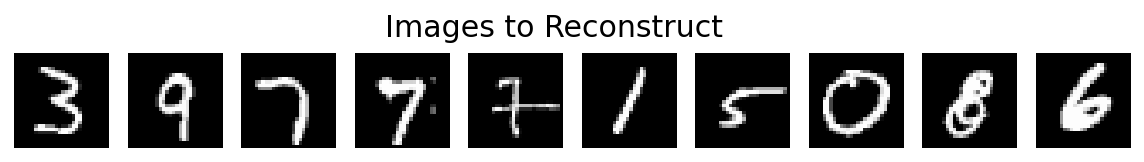

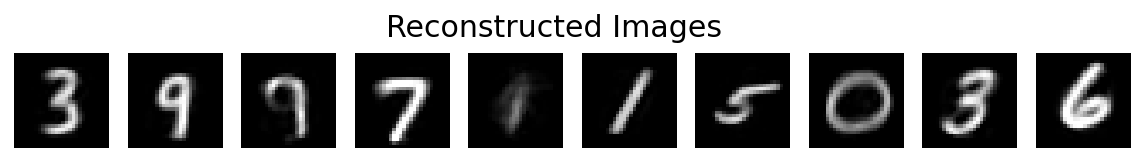

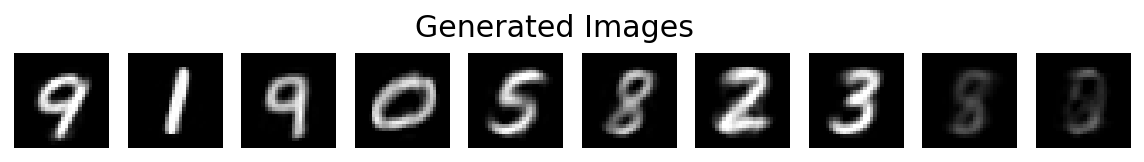

[86/100] total:[0.086] recon:[0.058] vq:[280.130]
[87/100] total:[0.086] recon:[0.058] vq:[281.020]
[88/100] total:[0.086] recon:[0.058] vq:[282.489]
[89/100] total:[0.086] recon:[0.058] vq:[284.070]
[90/100] total:[0.087] recon:[0.058] vq:[284.553]


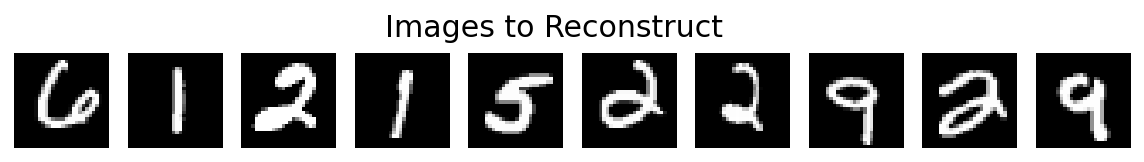

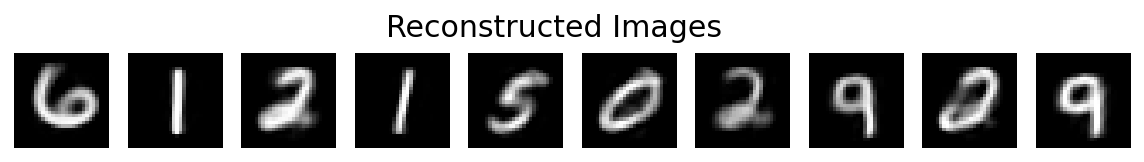

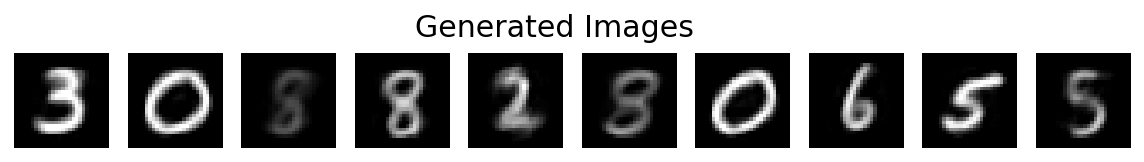

[91/100] total:[0.087] recon:[0.058] vq:[286.144]
[92/100] total:[0.087] recon:[0.058] vq:[286.702]
[93/100] total:[0.087] recon:[0.058] vq:[287.374]
[94/100] total:[0.087] recon:[0.058] vq:[288.975]
[95/100] total:[0.087] recon:[0.058] vq:[289.146]


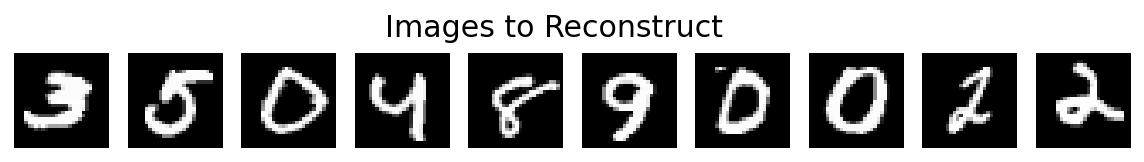

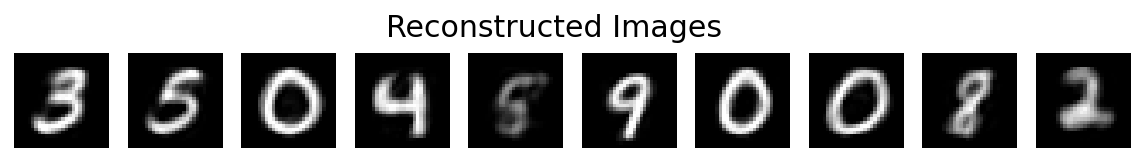

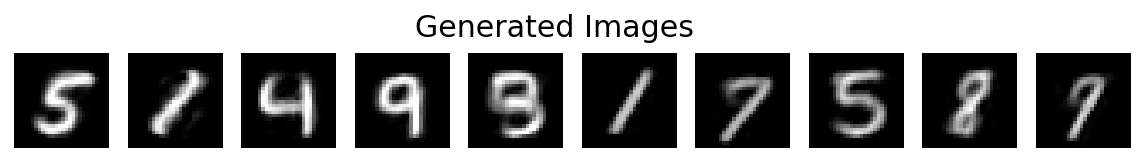

[96/100] total:[0.087] recon:[0.058] vq:[289.861]
[97/100] total:[0.087] recon:[0.058] vq:[290.008]
[98/100] total:[0.087] recon:[0.058] vq:[291.288]
[99/100] total:[0.087] recon:[0.058] vq:[290.951]


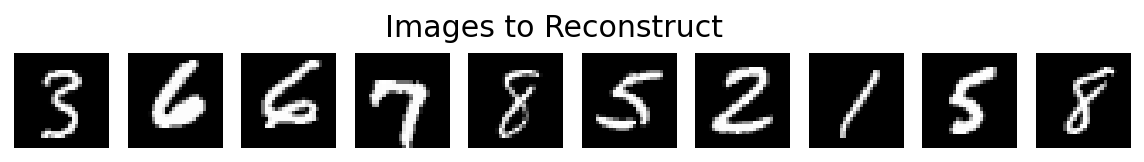

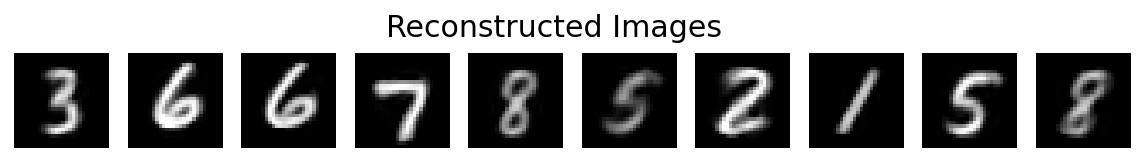

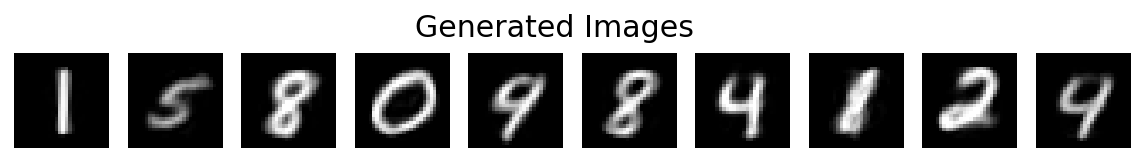

Done.


In [6]:
VQVAE = VectorQuantizedVariationalAutoEncoder(
                                            name     = 'VQVAE',
                                            x_dim    = 784,
                                            z_dim    = 32,
                                            h_dims   = [256,256],
                                            embedding_num   = 300,
                                            embedding_dim   = 32,
                                            commitment_beta = 0.25,
                                            actv_enc = nn.ReLU(),
                                            actv_dec = nn.ReLU(),
                                            actv_out = None,
                                            var_max  = None,
                                            device   ='cuda:0'
                                            )
VQVAE = VQVAE.to(VQVAE.device)
print ("[{}] instantiated with device:[{}]".format(VQVAE.name, VQVAE.device))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,5
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = VQVAE.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-8        # 1e-8
) 
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':c_train_np,
       'x_test_np':x_test_np,'c_test_np':c_test_np,'c_vecs':np.eye(10,10),
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# C.debug_plot_img(**dpi)
print ("Start training.")
x_train_torch = x_train_torch.to(VQVAE.device)
c_train_torch = c_train_torch.to(VQVAE.device)
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    loss_recon_sum,loss_vq_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = c_train_torch[batch_idx,:]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = VQVAE.loss_total(
            x               = x_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 1.0)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_vq_sum    = loss_vq_sum + n_batch*loss_info['loss_vq']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_vq_avg    = loss_vq_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] vq:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg, 10000*loss_vq_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        VQVAE.debug_plot_img(**dpi)
print ("Done.")